# Multivariate Standard Cauchy Distribution
In this experiment, we let GPSS and its competitors target the multivariate standard Cauchy distribution $\nu = \text{Cauchy}_d(0,I_d)$, given by the (unnormalized) density

$$
\varrho_{\nu}(x) = (1 + \Vert x \Vert^2)^{-(d+1)/2} ,
\qquad x \in \mathbb{R}^d ,
$$

in dimension $d = 100$. The Cauchy distribution is about as heavy-tailed as a distribution on $\mathbb{R}^d$ *can* be – so heavy-tailed in fact, that it does not even have a well-defined mean.

Such heavy-tailed target distributions are inherently challenging to MCMC samplers: In order to properly represent the target, a sampler must occasionally venture far into its tails, thereby generating a (potentially very large) number of samples that are strongly autocorrelated with each other, which negatively affects the number of *effective samples* the sampler ends up producing within a given computational budget. With this experiment, we demonstrate that GPSS can constitute a near-perfect solution to this issue by performing its trips into the tails so quickly that its samples barely show any autocorrelation even when the target is as heavy-tailed as a Cauchy distribution. Aside from demonstrating the utility of GPSS for targets with heavy ($=$ polynomial) tails, the experiment is meant to emphasize that GPSS can deal with any type of tails, from the lightest to the heaviest, quite unlike any other sampler we are aware of.

Aside from computing the usual performance metrics and plotting some summaries of the samplers' chains, we also let them perform an estimation task in this experiment. Specifically, we let them estimate a probability under the target distribution, namely

$$
p(b) := \nu(\{z \in \mathbb{R}^d \mid \Vert z \Vert > b, z_1 > 0\} ,
$$

where $z_1$ is the first entry of $z = (z_1,...,z_d)^T$ and $b > 0$ a fixed hyperparameter. We choose $b$ in a roundabout way that ensures the correct answer to be $p(b) = 0.25$ (note that we can find the correct answer for a given $b$ by numerically solving a one-dimensional integral and applying our knowledge of the target's structure). Informing them only of the value of $b$, we let the samplers continually estimate $p(b)$ from all the samples they have generated up to a given point. We then plot the progression of these estimates over the iterations (in log scale). The resulting plot gives an insight into the extreme performance differences between GPSS and its competitors for the standard Cauchy target.

In [ ]:
import sys
try:
    if "pyodide" in sys.modules:
        import piplite
        await piplite.install('fastprogress')
except:
    print("piplite not found, ignore this if you are not using Jupyterlite")

In [1]:
import scipy
import slice_sampling as ss
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
# Set experiment parameters
d = 100 # dimension, should be > 1
p = 0.25 # ground truth probability for estimation task
itnum = int(1e6) # number of chain iterations
window = int(5e4) # iterations to be shown in radii and log radii trace plots
path_prefix = "./plots/std_Cauchy_"

### Construct Target, Prepare Estimation Task

In [3]:
# compute bound corresponding to p
radius_density = lambda r: np.exp((d-1) * np.log(r) - (d+1)/2 * np.log(1 + r**2)) # (unnormalized) density of radii
C = quad(radius_density, 0, np.inf)[0]
eps = 1e-9 # binary search precision
lo = 1.0
hi = 1e6
while hi - lo > eps:
    mi = (lo + hi) / 2
    if quad(radius_density, mi, np.inf)[0] / C < 2*p:
        hi = mi
    else:
        lo = mi
b = lo
print("Probability {:.2f} corresponds to ball radius {:.4f}.".format(p,b))

Probability 0.25 corresponds to ball radius 14.7721.


/tmp/ipykernel_5961/2651080439.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  if quad(radius_density, mi, np.inf)[0] / C < 2*p:


In [4]:
tde_cnt = 0 # target density evaluation count

In [5]:
def log_density(x):
    global tde_cnt
    tde_cnt += 1
    return -(d+1)/2 * np.log(1 + alg.norm(x)**2)

### Run the Samplers

In [6]:
# Set sampler parameters
x_0 = np.ones(d)
w = d

In [7]:
samples_iid = rnd.chisquare(df=1, size=(itnum+1,1))**(-1/2) * rnd.normal(size=(itnum+1,d))

In [8]:
samples_gpss = ss.gibbsian_polar_ss(log_density, x_0, w, itnum)

In [9]:
tdes_gpss = tde_cnt
tde_cnt = 0

In [10]:
samples_ess = ss.naive_elliptical_ss(log_density, x_0, itnum)

In [11]:
tdes_ess = tde_cnt
tde_cnt = 0

In [12]:
samples_hruss = ss.hit_and_run_uniform_ss(log_density, x_0, w, itnum)

In [13]:
tdes_hruss = tde_cnt
tde_cnt = 0

### Collect Outputs, Compute Performance Metrics, Conduct Estimation Task

In [14]:
snames = ["Exact", "GPSS", "HRUSS", "ESS"]
long_snames = ["Exact Sampling", "Gibbsian Polar Slice Sampling", "Hit-and-Run Uniform Slice Sampling", "Elliptical Slice Sampling"]
nsam = len(snames)
samples = [samples_iid, samples_gpss, samples_hruss, samples_ess]
msamples = mcu.get_margs_list(samples, 0)
tdes_per_it = np.array([0.0, tdes_gpss, tdes_hruss, tdes_ess]) / itnum # target density evals per iteration
radii = mcu.get_radii_list(samples)
log_radii = [np.log(rs) for rs in radii]
p_ests = [np.cumsum( (rs > b) * (msams > 0) ) / np.arange(1,itnum+2) for rs, msams in zip(radii, msamples)]
iats = mcu.iat_list(log_radii, maxl=itnum//10) # this maxl may still be too small for ESS / HRUSS
radii_window = [rs[:window] for rs in radii]
log_radii_window = [lrs[:window] for lrs in log_radii]

In [15]:
pd.DataFrame(
    np.array([long_snames, np.round(tdes_per_it, 2), np.round(iats, 2)]).T, 
    columns = ["Sampler", "TDEs/it", "IAT"]
)

Sampler TDEs/it       IAT
0                      Exact Sampling     0.0      1.01
1       Gibbsian Polar Slice Sampling     6.9      8.59
2  Hit-and-Run Uniform Slice Sampling    8.46  51346.93
3           Elliptical Slice Sampling    5.86  35543.94

### Plotting

In [16]:
def pb_conv_plot(est_list, names, filename, figsize=(4.5,3), dpi=250):
    nsam = len(names)
    default_cycler = plt.rcParams["axes.prop_cycle"]
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0, 0.9, nsam)))
    plt.figure(figsize=figsize, dpi=dpi)
    plt.xlabel("iterations")
    plt.ylabel("probability p(b)")
    plt.xscale("log")
    plt.ylim(0,2*p)
    for ests in est_list:
        plt.plot(range(1,itnum+2), ests)
    plt.plot([0,itnum], [p,p], color="black", linestyle="dashed", zorder=0)
    plt.legend(names, loc="upper left")
    pfs.wrapup(path_prefix + filename + ".png")
    plt.rcParams["axes.prop_cycle"] = default_cycler

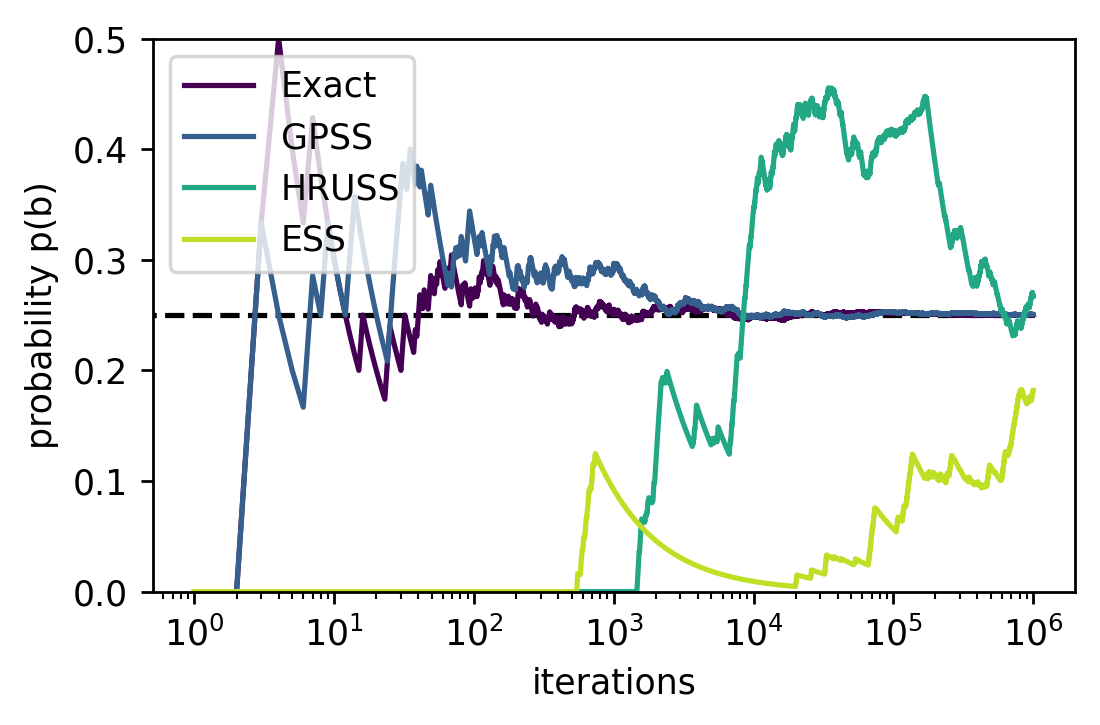

In [17]:
pb_conv_plot(p_ests, snames, "conv_all")

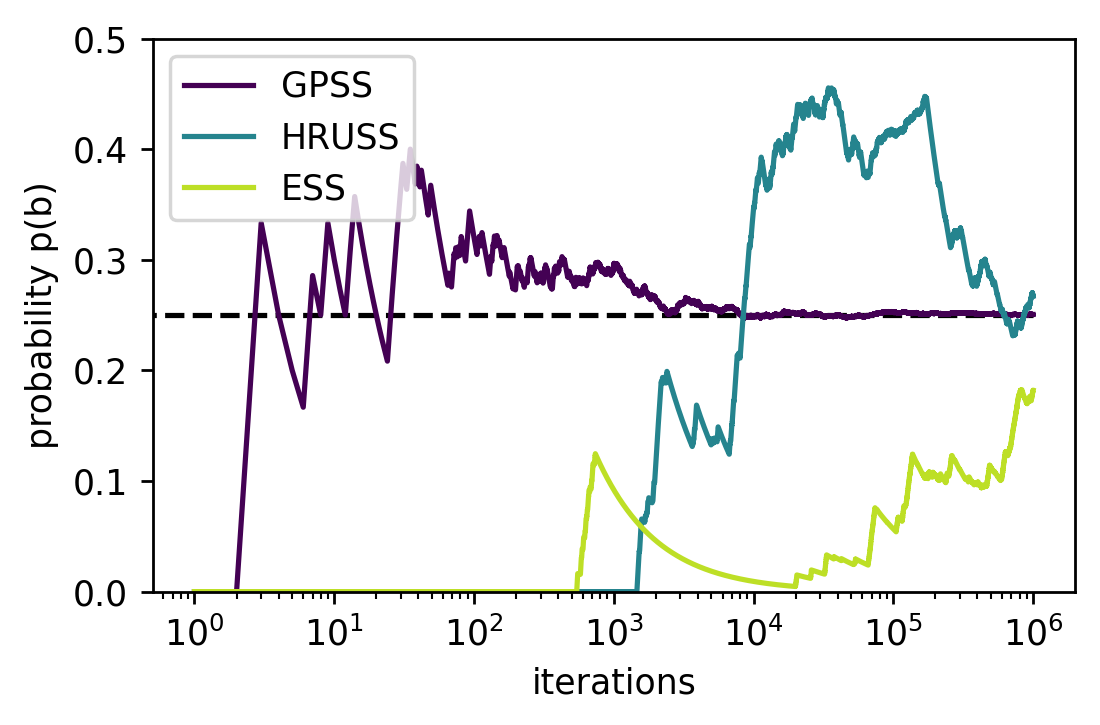

In [18]:
pb_conv_plot(p_ests[1:], snames[1:], "conv_ss")

**Note:** The above plot shows that the estimates produced by GPSS begin oscillating around the true answer after just a few iterations and have converged to a satisfying extent after just around $10^4$ iterations, whereas HRUSS and ESS require hundreds or even thousands of iterations just to reach the target set and can be expected to oscillate around the correct answer for many orders of magnitude longer than GPSS before converging in a similar fashion.

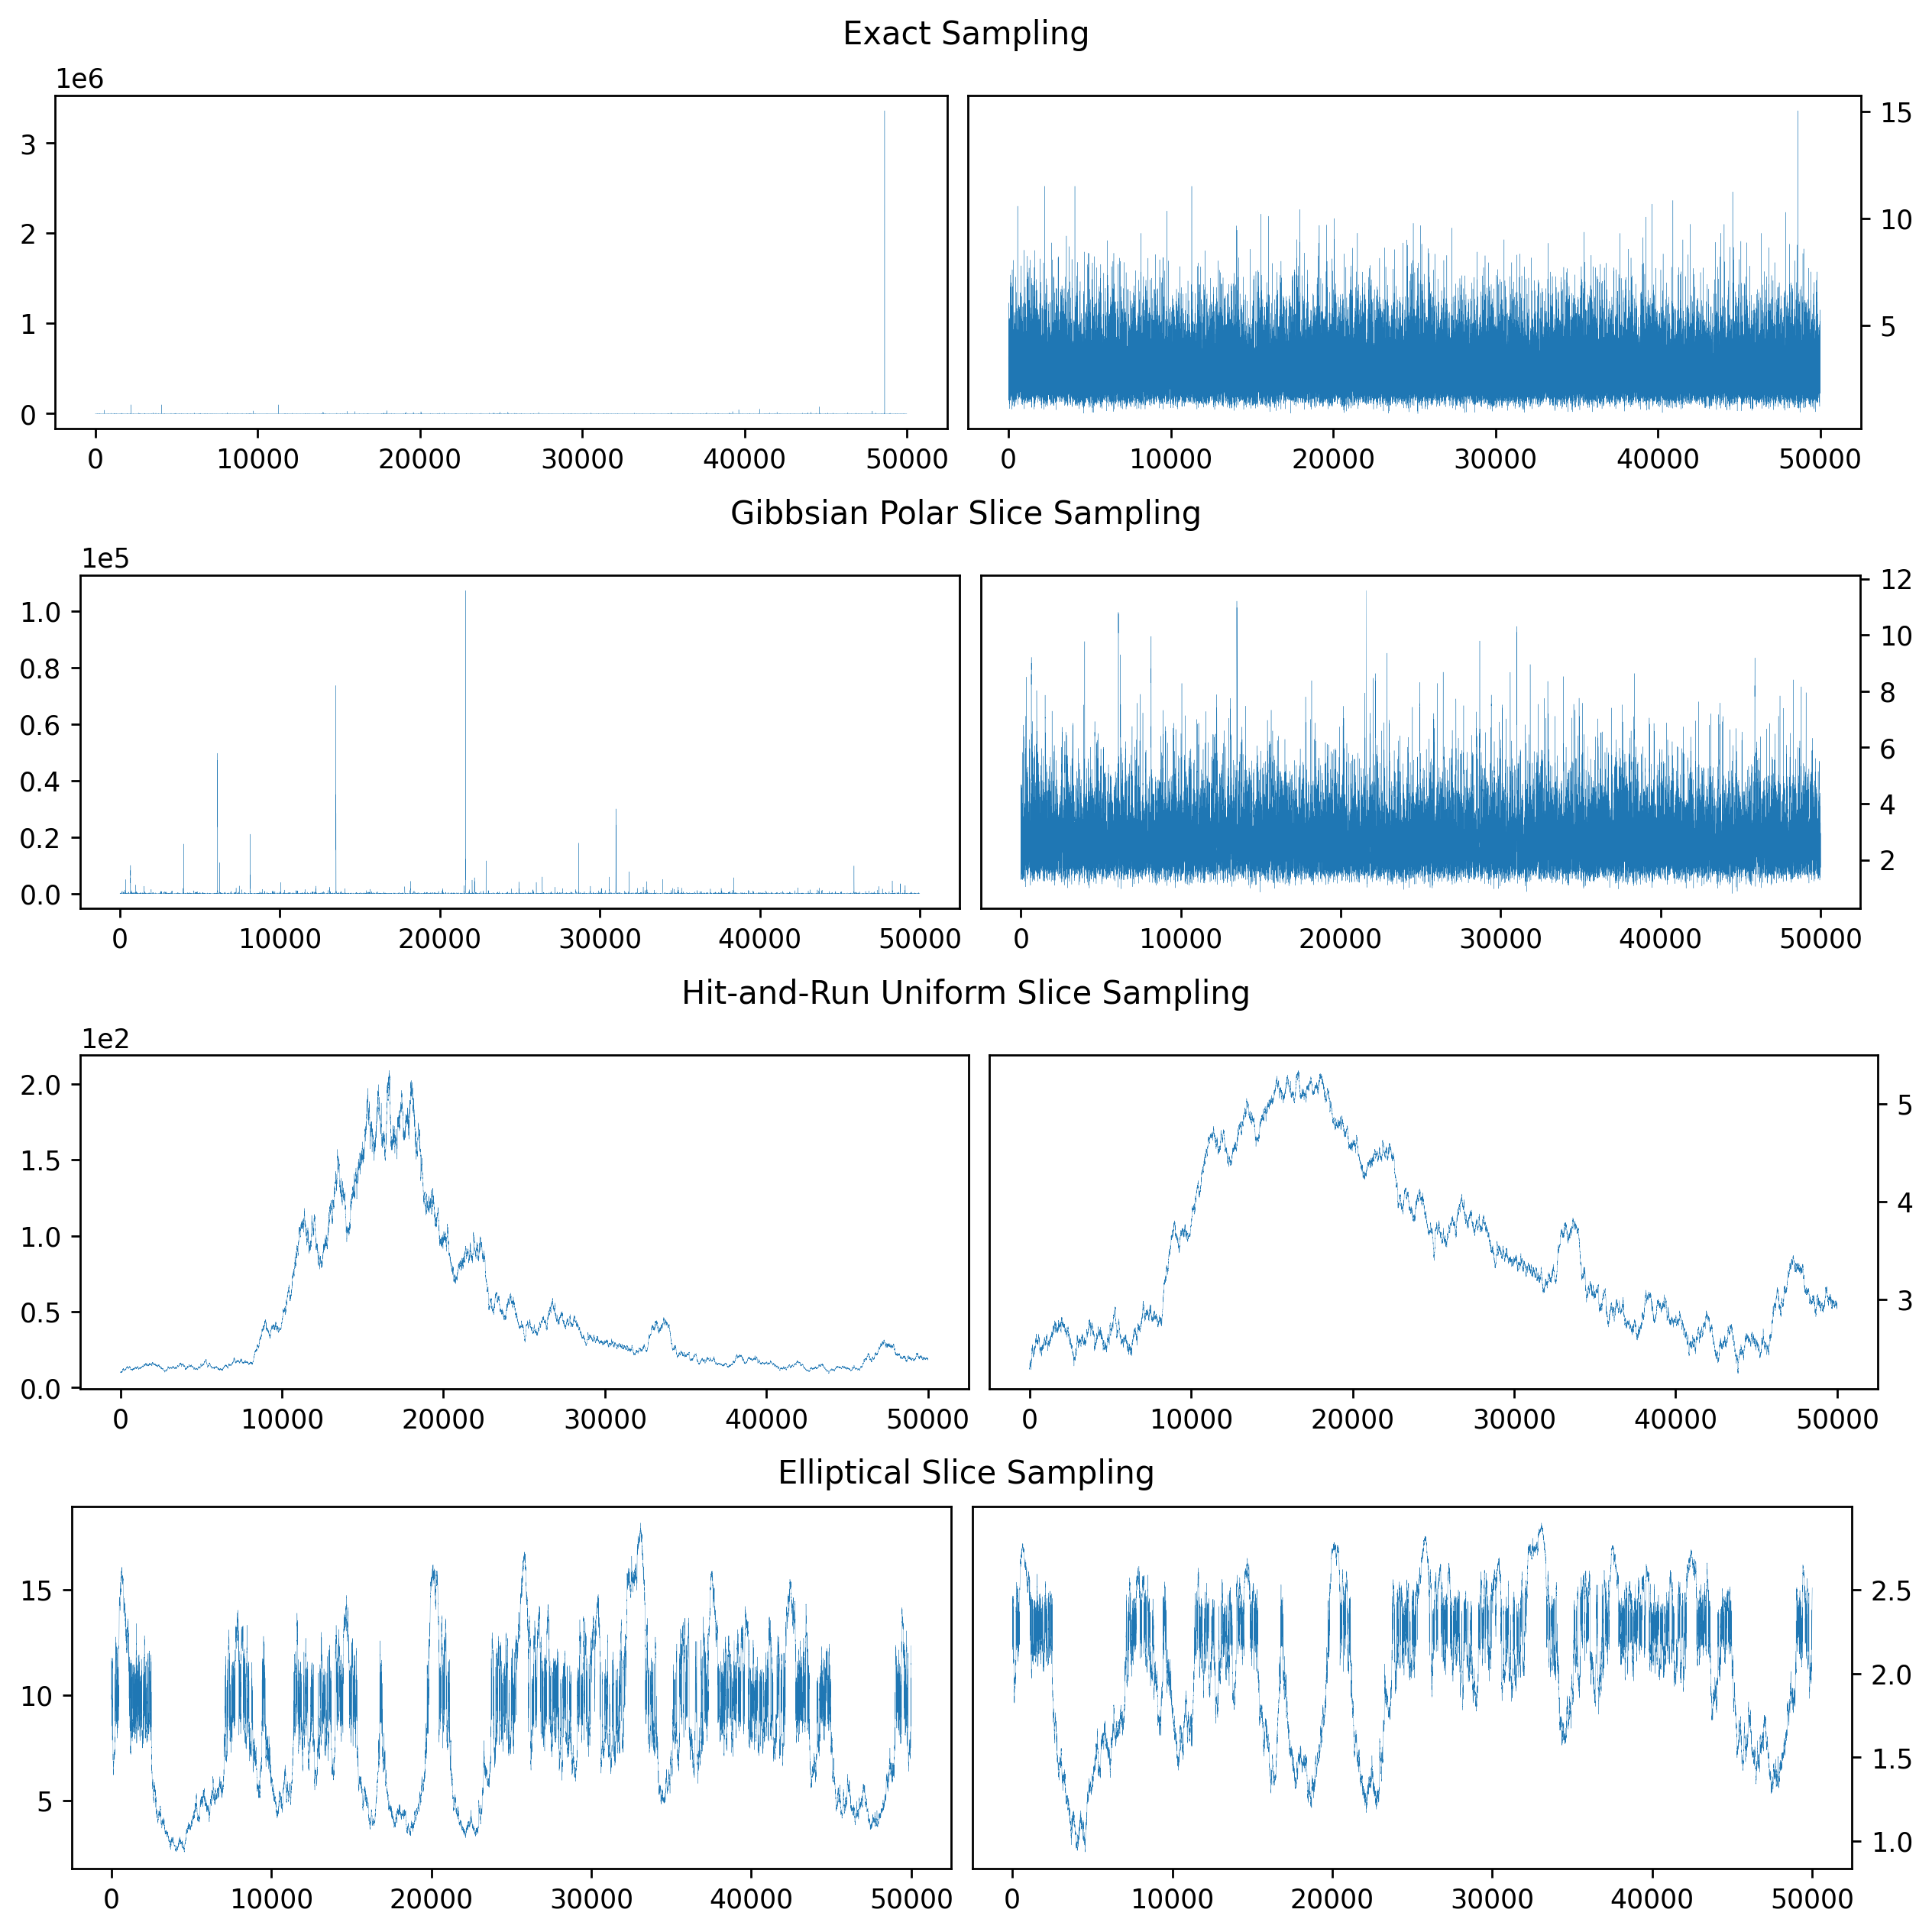

In [19]:
pfs.plot_traces_2_col(
    radii_window, log_radii_window, long_snames, dpi=250, lw1=0.1, lw2=0.1, filepath = path_prefix + "radii.png"
)